## Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from function import Eddies_Tools
import numpy as np

from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB





## EDA/Cleaning

In [2]:
trade_chat = pd.read_csv('data\\trade_chat.csv', index_col=0)

In [3]:
trade_chat

,date,time,text,sentiment,target
0,2/22/2022,8:14:35,how long will downtime be,2,Patch
1,2/22/2022,8:14:40,8 hours,2,Patch
2,2/22/2022,8:14:42,few hours,2,Patch
3,2/22/2022,8:14:42,8 hours?,2,Patch
4,2/22/2022,8:14:42,7hrs,2,Patch
...,...,...,...,...,...
1856,2/23/2022,1:15:55,ok cool,3,Patch
1857,2/23/2022,1:16:56,CHANGE NUDES FOR MONTH SUB PLS,2,Chat
1858,2/23/2022,1:17:10,help a gal out,2,Chat
1859,2/23/2022,1:17:19,perhaps,2,Chat


In [4]:
trade_chat['text'].duplicated().value_counts()

False    1387
True      474
Name: text, dtype: int64

In [5]:
trade_chat.drop_duplicates(subset= 'text', inplace=True)
trade_chat.reset_index(drop=True, inplace=True)

In [6]:
trade_chat['text'].duplicated().value_counts()

False    1387
Name: text, dtype: int64

In [7]:
trade_chat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1387 entries, 0 to 1386
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       1387 non-null   object
 1   time       1387 non-null   object
 2   text       1387 non-null   object
 3   sentiment  1387 non-null   int64 
 4   target     1387 non-null   object
dtypes: int64(1), object(4)
memory usage: 54.3+ KB


In [8]:
trade_chat.sentiment.value_counts()

2    891
1    438
3     58
Name: sentiment, dtype: int64

In [9]:
trade_chat.target.value_counts()

Chat        677
Patch       482
Trade        78
LFM          65
Boosting     40
Bug          26
LFG          18
bug           1
Name: target, dtype: int64

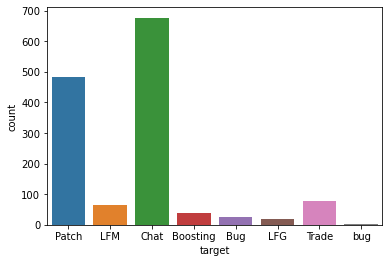

In [10]:
ax=  sns.countplot(x='target', data= trade_chat)

In [11]:
trade_chat[trade_chat.target == 'bug']

,date,time,text,sentiment,target
684,2/22/2022,20:42:05,Arbitor is on break,1,bug


In [12]:
trade_chat.target[684] = 'Bug'

C:\Users\edelp\AppData\Local\Temp/ipykernel_34148/82308061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_chat.target[684] = 'Bug'


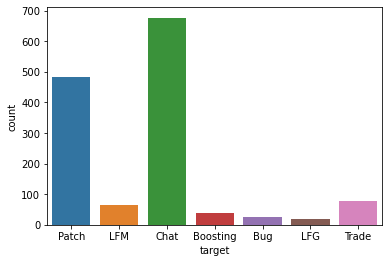

In [13]:
total_target =  sns.countplot(x='target', data= trade_chat)

In [14]:
patch = trade_chat[trade_chat.target == 'Patch']
chat = trade_chat[trade_chat.target == 'Chat']

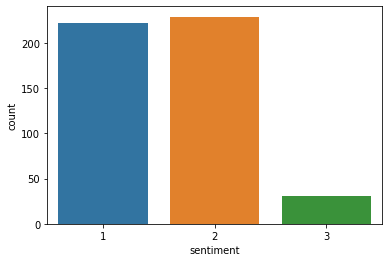

In [15]:
patch_sentiment =  sns.countplot(x='sentiment', data= patch)

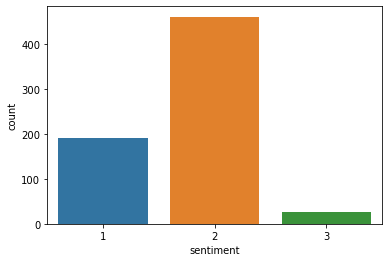

In [16]:
chat_sentiment =  sns.countplot(x='sentiment', data= chat)

In [17]:
patch.sentiment.value_counts()

2    229
1    222
3     31
Name: sentiment, dtype: int64

In [18]:
chat.sentiment.value_counts()

2    461
1    190
3     26
Name: sentiment, dtype: int64

## NLP

In [19]:
et = Eddies_Tools()

In [20]:
s_words = stopwords.words('english')
tokenizer = RegexpTokenizer(r"(?u)\b\w\w+\b")
et = Eddies_Tools()

In [21]:
tc_tokenized = et.nlp_tokenizer(trade_chat, tokenizer, s_words)

In [22]:
tc_tokenized

,date,time,text,sentiment,target,text_tokenized,joined_tokens
0,2/22/2022,8:14:35,how long will downtime be,2,Patch,"[long, downtime]",long downtime
1,2/22/2022,8:14:40,8 hours,2,Patch,[hours],hours
2,2/22/2022,8:14:42,few hours,2,Patch,[hours],hours
3,2/22/2022,8:14:42,8 hours?,2,Patch,[hours],hours
4,2/22/2022,8:14:42,7hrs,2,Patch,[7hrs],7hrs
...,...,...,...,...,...,...,...
1382,2/23/2022,1:15:55,ok cool,3,Patch,"[ok, cool]",ok cool
1383,2/23/2022,1:16:56,CHANGE NUDES FOR MONTH SUB PLS,2,Chat,"[CHANGE, NUDES, FOR, MONTH, SUB, PLS]",CHANGE NUDES FOR MONTH SUB PLS
1384,2/23/2022,1:17:10,help a gal out,2,Chat,"[help, gal]",help gal
1385,2/23/2022,1:17:19,perhaps,2,Chat,[perhaps],perhaps


In [23]:
chat_tokenized = tc_tokenized[tc_tokenized.target == 'Chat']
patch_tokenized = tc_tokenized[tc_tokenized.target == 'Patch']

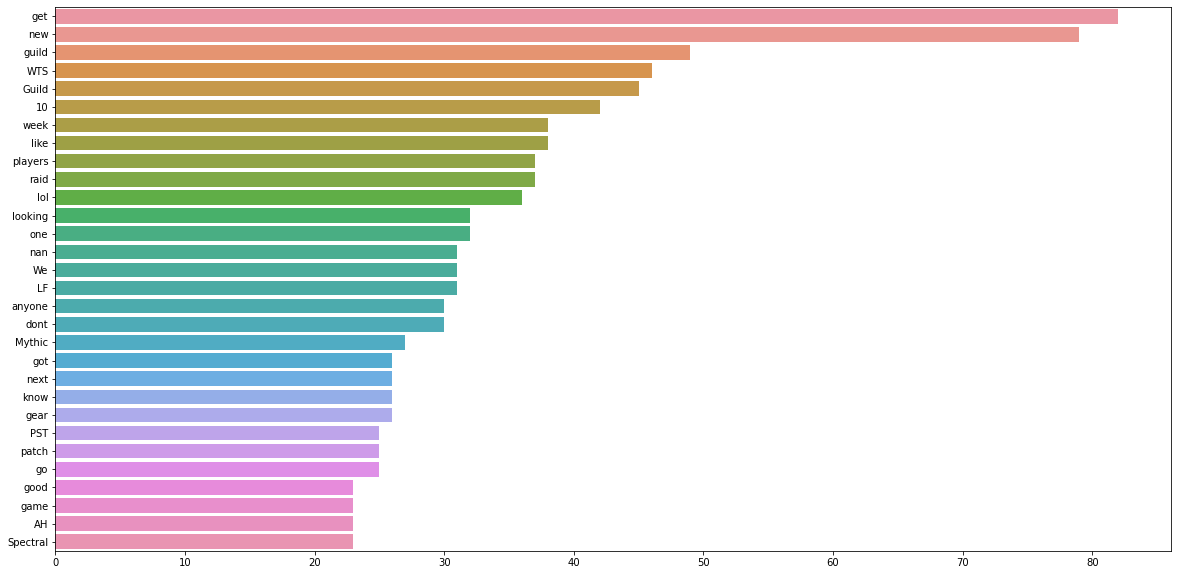

In [24]:
fdist = FreqDist(tc_tokenized.text_tokenized.explode())

top_30_words = list(zip(*fdist.most_common(30)))

tokens = np.array(top_30_words[0])
count = np.array(top_30_words[1])

fig, ax = plt.subplots(figsize=(20,10))

top_30_chart = sns.barplot(x= count, y= tokens)


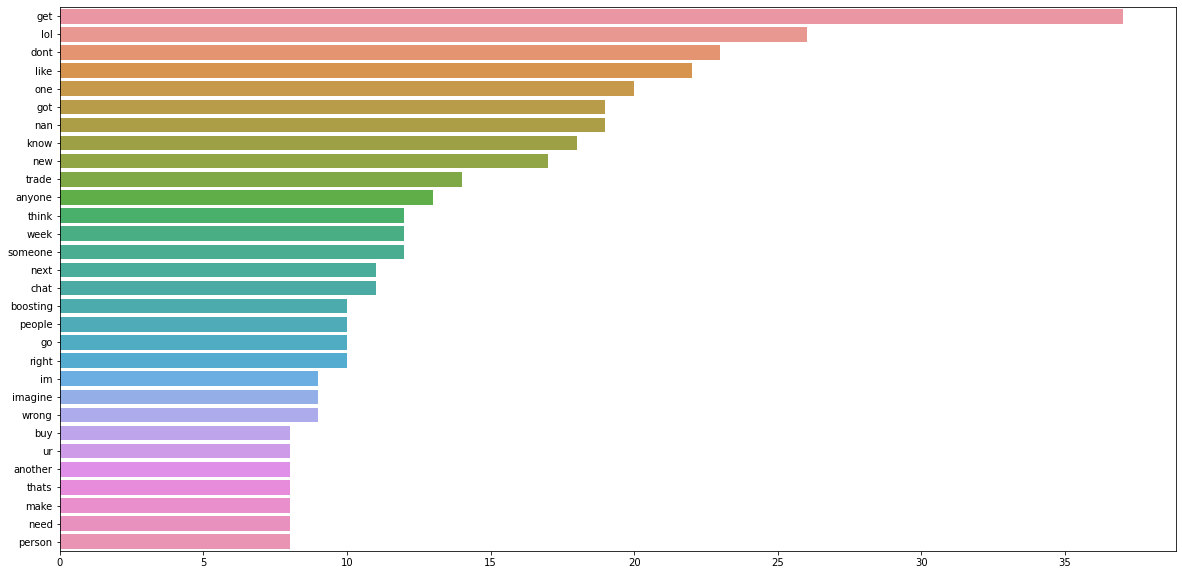

In [25]:
chat_fdist = FreqDist(chat_tokenized.text_tokenized.explode())

top_30_words = list(zip(*chat_fdist.most_common(30)))

tokens = np.array(top_30_words[0])
count = np.array(top_30_words[1])

fig, ax = plt.subplots(figsize=(20,10))

top_30_chart = sns.barplot(x= count, y= tokens)

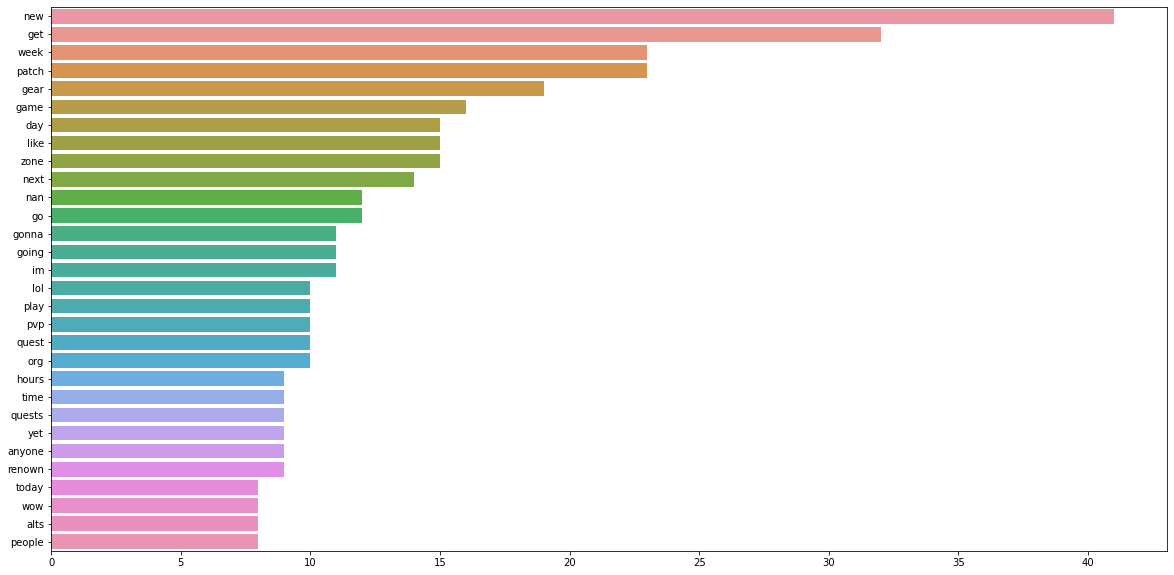

In [26]:
patch_fdist = FreqDist(patch_tokenized.text_tokenized.explode())

top_30_words = list(zip(*patch_fdist.most_common(30)))

tokens = np.array(top_30_words[0])
count = np.array(top_30_words[1])

fig, ax = plt.subplots(figsize=(20,10))

top_30_chart = sns.barplot(x= count, y= tokens)

In [27]:

counter = 0
for lists in patch_tokenized.text_tokenized:
    if lists == []:
        counter += 1
        print('YES')

counter

YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES
YES


12

In [28]:
chat_tokenized.text_tokenized.loc[10:70]

12    [wow, said, main, account, ban, anyone, help, ...
13    [nerd, raging, hard, untethered, rage, knows, ...
14              [Eh, lol, wanna, risk, getting, banned]
15                      [buy, new, one, blizzard, shop]
16                                             [banned]
17                                          [SAM, DEAN]
18                   [got, banned, d2r, deserved, haha]
20                 [many, times, spam, nword, malabrah]
21    [said, selling, runs, cause, play, carry, stre...
22                                    [oh, botted, lol]
23                                  [feel, ban, unjust]
24                                                [lol]
25                                                 [xd]
26                                                 [tt]
27          [yes, yes, unjust, ban, sure, Get, deserve]
28                                                   []
29                       [Ok, got, banned, last, night]
30                           [got, boosted, ur, 

In [29]:
trade_chat.loc[34]

date         2/22/2022
time           8:18:11
text                =x
sentiment            2
target            Chat
Name: 34, dtype: object

In [30]:
neg_patch = patch_tokenized[patch_tokenized.sentiment == 1]
neg_chat = chat_tokenized[chat_tokenized.sentiment == 1]

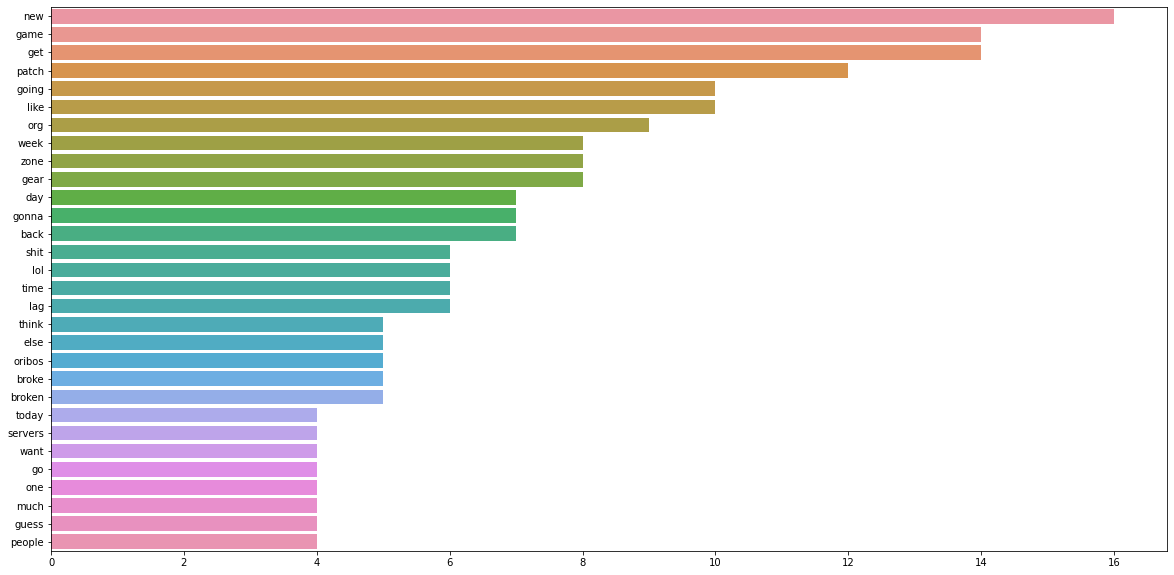

In [31]:
neg_patch_fdist = FreqDist(neg_patch.text_tokenized.explode())

top_30_words = list(zip(*neg_patch_fdist.most_common(30)))

tokens = np.array(top_30_words[0])
count = np.array(top_30_words[1])

fig, ax = plt.subplots(figsize=(20,10))

top_30_chart = sns.barplot(x= count, y= tokens)

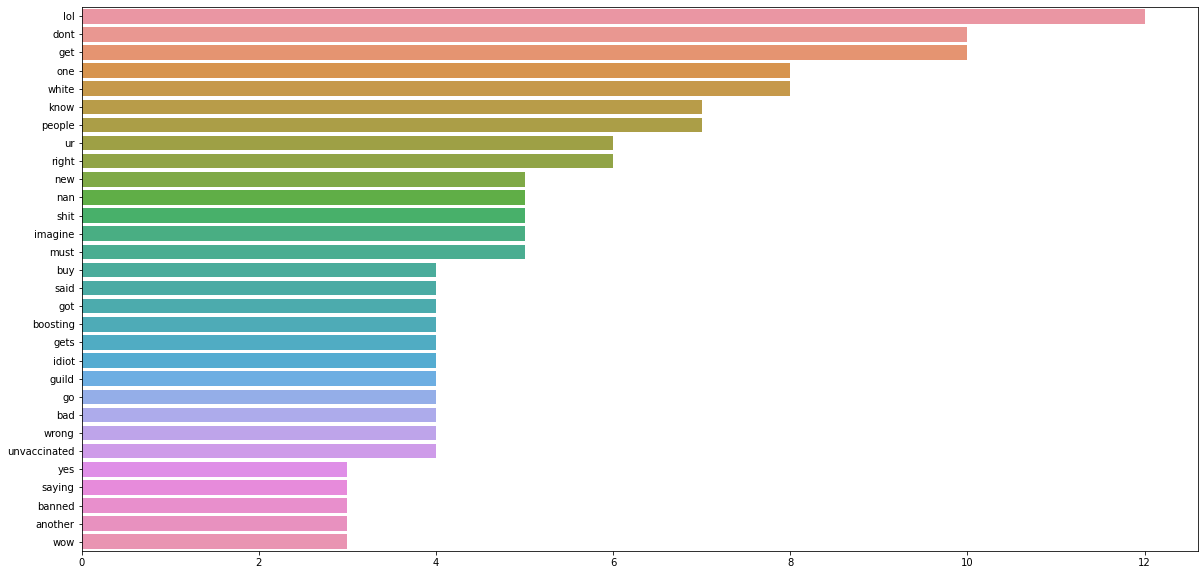

In [32]:
neg_chat_fdist = FreqDist(neg_chat.text_tokenized.explode())

top_30_words = list(zip(*neg_chat_fdist.most_common(30)))

tokens = np.array(top_30_words[0])
count = np.array(top_30_words[1])

fig, ax = plt.subplots(figsize=(20,10))

top_30_chart = sns.barplot(x= count, y= tokens)

## Baseline Models

In [33]:
X = tc_tokenized['joined_tokens']
y_sentiment = tc_tokenized['sentiment']
y_target = tc_tokenized['target']

### Sentiment Models

In [34]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y_sentiment, test_size= 0.25, random_state=5)

In [35]:
y_test_s.value_counts()

2    224
1    108
3     15
Name: sentiment, dtype: int64

In [36]:
s_labels = ['neg', 'neutral', 'pos']

In [37]:
sentiment_models = {}

#### Stochastic Gradient Descent Model

In [38]:
sgd_sentiment = Pipeline([('vect', CountVectorizer()), 
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier(random_state=5)),
              ])

cv_mean, accuracy, y_pred, model = et.run_model(X, y_sentiment, sgd_sentiment)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

sentiment_models['SGD'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}


CV Mean: 0.6808
Accuracy: 0.6715


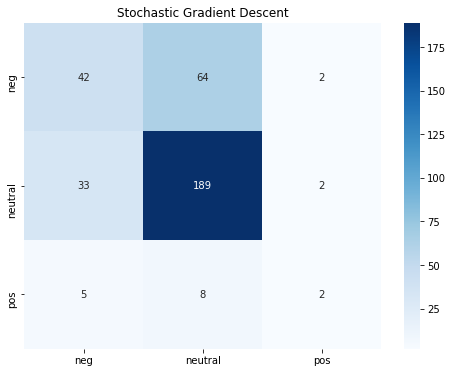

In [39]:
cm = confusion_matrix(y_test_s, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=s_labels, yticklabels=s_labels)
ax.set_title('Stochastic Gradient Descent');

#### Random Forest Model

In [40]:
rfc_sentiment = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(random_state=5)),
              ])

cv_mean, accuracy, y_pred, model = et.run_model(X, y_sentiment, rfc_sentiment)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

sentiment_models['RFC'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}


CV Mean: 0.7048
Accuracy: 0.6657


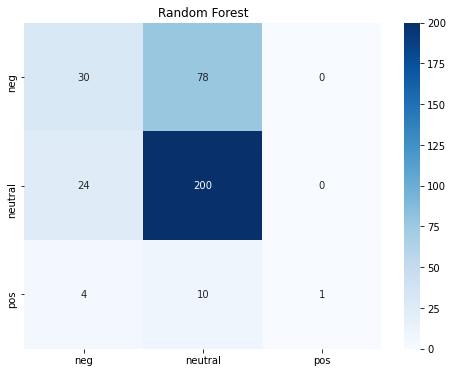

In [41]:
cm = confusion_matrix(y_test_s, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=s_labels, yticklabels=s_labels)
ax.set_title('Random Forest');

#### Naive Bayes Model

In [42]:
naive_sentiment = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

cv_mean, accuracy, y_pred, model = et.run_model(X, y_sentiment, naive_sentiment)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

sentiment_models['Naive'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}


CV Mean: 0.6894
Accuracy: 0.6888


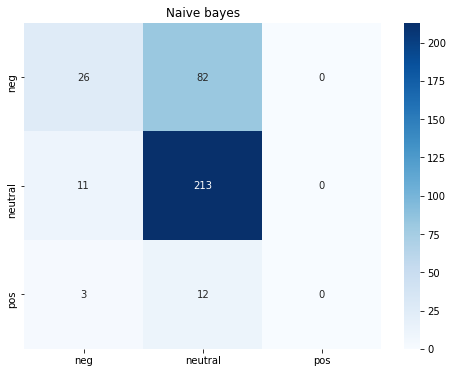

In [43]:
cm = confusion_matrix(y_test_s, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=s_labels, yticklabels=s_labels)
ax.set_title('Naive bayes');

#### Logistic Regression Model

In [44]:
lg_sentiment = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression()),
              ])

cv_mean, accuracy, y_pred, model = et.run_model(X, y_sentiment, lg_sentiment)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

sentiment_models['LogReg'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}


CV Mean: 0.701
Accuracy: 0.6859


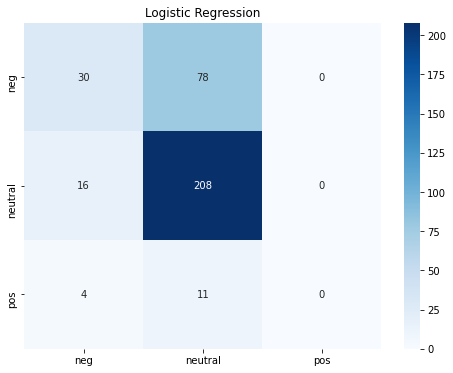

In [45]:
cm = confusion_matrix(y_test_s, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=s_labels, yticklabels=s_labels)
ax.set_title('Logistic Regression');

In [46]:
sentiment_models

{'SGD': {'CV Mean': 0.6808, 'Accuracy': 0.6715},
 'RFC': {'CV Mean': 0.7048, 'Accuracy': 0.6657},
 'Naive': {'CV Mean': 0.6894, 'Accuracy': 0.6888},
 'LogReg': {'CV Mean': 0.701, 'Accuracy': 0.6859}}

### Target Models

In [47]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y_target, test_size= 0.25, random_state=5)

In [48]:
target_models = {}

In [69]:
y_test_t.value_counts()

Chat        175
Patch       113
Trade        18
LFM          15
Boosting     12
Bug           8
LFG           6
Name: target, dtype: int64

In [50]:
t_labels = sorted(list(tc_tokenized.target.value_counts().index))

#### Stochastic Gradient Descent Model

In [51]:
sgd_target = Pipeline([('vect', CountVectorizer()), 
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier(random_state=5)),
              ])

cv_mean, accuracy, y_pred, model = et.run_model(X, y_target, sgd_target)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

target_models['SGD'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}



CV Mean: 0.6769
Accuracy: 0.6369


Text(0.5, 1.0, 'Stochastic Gradient Descent')

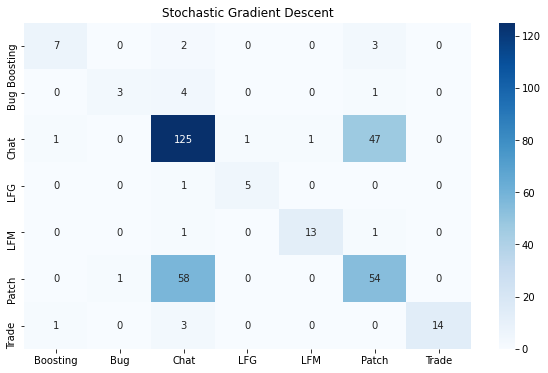

In [52]:
cm = confusion_matrix(y_test_t, y_pred)

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=t_labels, yticklabels=t_labels)
ax.set_title('Stochastic Gradient Descent')

In [66]:
X_test_t

980                    Kyle Rittenhouse would stop Russia
1358                                   depends far behind
784                           someone give 5k gold please
693                                         38ms fine day
34                                                       
                              ...                        
176     heard dumbasses getting boosting Mage tower LM...
395             Need x4 guild signatures 5k per signature
1270                                                 amen
684                                         Arbitor break
437                                                  lmao
Name: joined_tokens, Length: 347, dtype: object

#### Random Forest Model

In [53]:
rfc_target = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(random_state=5)),
              ])

cv_mean, accuracy, y_pred, model = et.run_model(X, y_target, rfc_target)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

target_models['RFC'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}


CV Mean: 0.675
Accuracy: 0.634


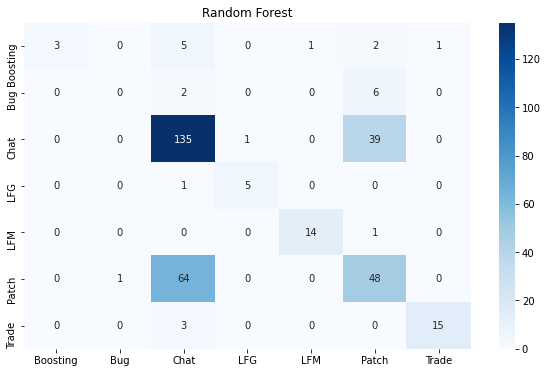

In [54]:
cm = confusion_matrix(y_test_t, y_pred)

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=t_labels, yticklabels=t_labels)
ax.set_title('Random Forest');

#### Naive Bayes Model

In [55]:
naive_target = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

cv_mean, accuracy, y_pred, model = et.run_model(X, y_target, naive_target)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

target_models['Naive'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}

CV Mean: 0.6394
Accuracy: 0.6167


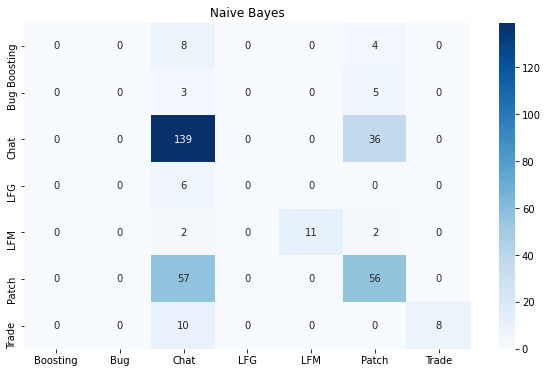

In [56]:
cm = confusion_matrix(y_test_t, y_pred)

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=t_labels, yticklabels=t_labels)
ax.set_title('Naive Bayes');

#### Logistic Regression Model

In [57]:
lg_target = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression()),
              ])

cv_mean, accuracy, y_pred, model = et.run_model(X, y_target, lg_target)

print(f'CV Mean: {cv_mean}')
print(f'Accuracy: {accuracy}')

target_models['LogReg'] = {'CV Mean': cv_mean, 'Accuracy': accuracy}

CV Mean: 0.6519
Accuracy: 0.6311


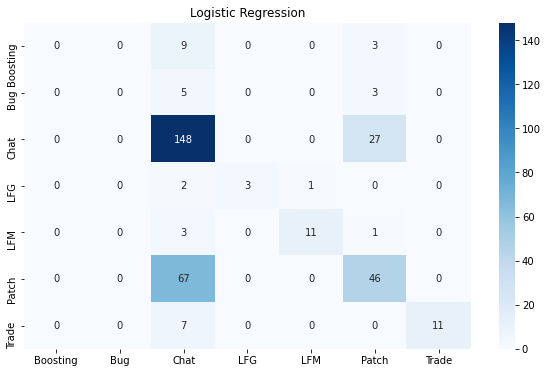

In [58]:
cm = confusion_matrix(y_test_t, y_pred)

fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=t_labels, yticklabels=t_labels)
ax.set_title('Logistic Regression');

In [59]:
target_models

{'SGD': {'CV Mean': 0.6769, 'Accuracy': 0.6369},
 'RFC': {'CV Mean': 0.675, 'Accuracy': 0.634},
 'Naive': {'CV Mean': 0.6394, 'Accuracy': 0.6167},
 'LogReg': {'CV Mean': 0.6519, 'Accuracy': 0.6311}}

### Base Model Performance

In [60]:
s_model_df = pd.DataFrame()
s_bmp_labels = list(sentiment_models.keys())

In [61]:
model_list = []
cv_list = []
acc_list = []

for model_name in s_bmp_labels:
    cv_list.append(list(sentiment_models[model_name].values())[0])
    acc_list.append(list(sentiment_models[model_name].values())[1])

s_model_df['model'] = sentiment_models.keys()
s_model_df['cv_mean'] = cv_list
s_model_df['accuracy'] = acc_list

s_model_df


,model,cv_mean,accuracy
0,SGD,0.6808,0.6715
1,RFC,0.7048,0.6657
2,Naive,0.6894,0.6888
3,LogReg,0.7010,0.6859


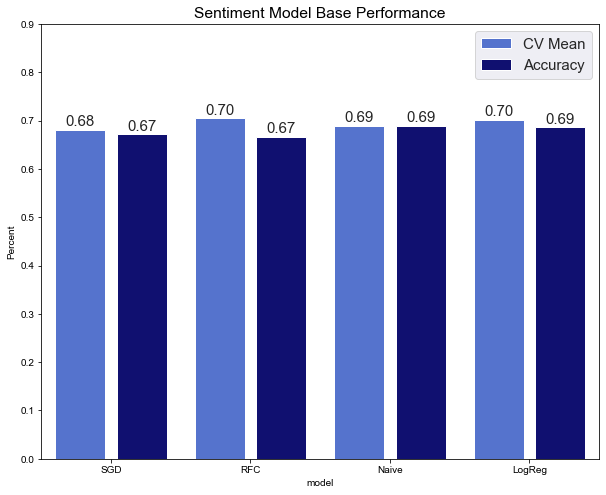

In [62]:
fig, ax = plt.subplots(figsize=(10,8))
width = .45
sns.set(font_scale = 1.3)

ax1 = sns.barplot(x='model', y='cv_mean', data=s_model_df, color='royalblue', label='CV Mean')

for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width)



ax2 = sns.barplot(x='model', y='accuracy', data=s_model_df, color='navy', label='Accuracy')

for bar in ax.containers[1]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width))
    bar.set_width(w * width)

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

ax.set_ylabel('Percent')
ax.set_ybound(upper= .9)
ax.legend(fontsize= 15)
ax.set_title('Sentiment Model Base Performance')


plt.show()

In [63]:
t_model_df = pd.DataFrame()
t_bmp_labels = list(target_models.keys())

In [64]:
model_list = []
cv_list = []
acc_list = []

for model_name in t_bmp_labels:
    cv_list.append(list(target_models[model_name].values())[0])
    acc_list.append(list(target_models[model_name].values())[1])

t_model_df['model'] = target_models.keys()
t_model_df['cv_mean'] = cv_list
t_model_df['accuracy'] = acc_list

t_model_df

,model,cv_mean,accuracy
0,SGD,0.6769,0.6369
1,RFC,0.6750,0.6340
2,Naive,0.6394,0.6167
3,LogReg,0.6519,0.6311


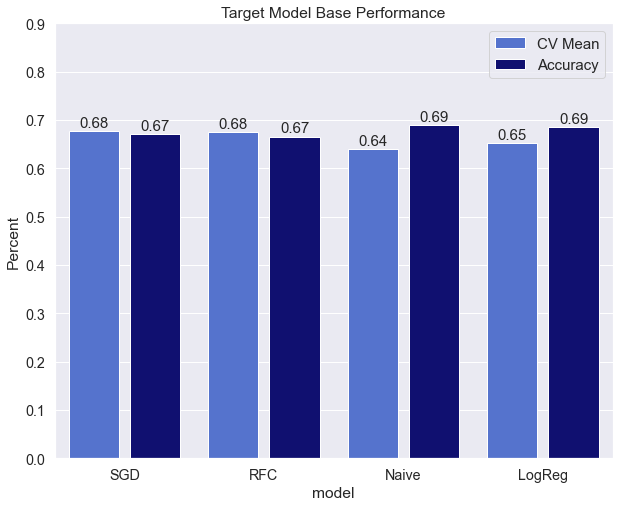

In [65]:
fig, ax = plt.subplots(figsize=(10,8))
width = .45
sns.set(font_scale = 1.3)

ax1 = sns.barplot(x='model', y='cv_mean', data=t_model_df, color='royalblue', label='CV Mean')

for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width)



ax2 = sns.barplot(x='model', y='accuracy', data=s_model_df, color='navy', label='Accuracy')

for bar in ax.containers[1]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width))
    bar.set_width(w * width)

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

ax.set_ylabel('Percent')
ax.set_ybound(upper= .9)
ax.legend(fontsize= 15)
ax.set_title('Target Model Base Performance')


plt.show()